<a href="https://colab.research.google.com/github/gjoni/trDesign/blob/master/02-GD/notebooks/TrDesign_GD_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TrDesign**
For details see following link: https://github.com/gjoni/trDesign



download mystery code

In [1]:
%%bash
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/models.py
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/utils.py
wget -qnc https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/1QYS.pdb
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/design/to_pdb.py
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/models.zip
wget -qnc https://files.ipd.uw.edu/krypton/TrRosetta/bkgr_models.zip
unzip -qqo models.zip
unzip -qqo bkgr_models.zip
pip -q install py3Dmol

In [2]:
import numpy as numpy
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from IPython.display import HTML
import py3Dmol

from utils import *
from models import *
from to_pdb import *

Extra functions for plotting (will be explained later with each use)

In [20]:
def plot_feat(x):
  '''plot each feature'''
  plt.figure(figsize=(4*4,4))
  for n,(k,v) in enumerate(split_feat(x).items()):
    plt.subplot(1,4,n+1); plt.title(k)
    plt.imshow(np.squeeze(v).argmax(-1))
  plt.show()

def animate(design):
  '''animate given trajectory'''
  fig, imgs = plt.figure(figsize=(6,3), dpi=100),[]
  gs = GridSpec(1,4, figure=fig)
  ax1 = fig.add_subplot(gs[0,:3]); ax1.axis(False)
  ax2 = fig.add_subplot(gs[0,3]); ax2.axis(False)
  # go through each step along traj
  for k,out in enumerate(design["traj"]):
    # plot distance (contact map)
    pred = split_feat(out["feat"])["dist"][0].argmax(-1)
    # plot pssm (probability of amino acid at each position)
    pssm = out["pssm"][0,0]
    im1 = ax1.imshow(pred, animated=True)
    im2 = ax2.imshow(pssm, animated=True,vmin=0,vmax=1)
    imgs.append([im1,im2])
  ani = animation.ArtistAnimation(fig, imgs, blit=True, interval=40)
  plt.close()
  return ani.to_html5_video()

def get_pdb(design, pdb_filename="out.pdb"):
  '''given features, return approx. 3D structure'''
  seq = N_to_AA(design["I"].argmax(-1))[0]
  xyz, dm = feat_to_xyz(design["feat"])
  save_PDB(pdb_filename, xyz, dm, seq)

  p = py3Dmol.view()
  p.addModel(open(pdb_filename,'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

#**PART 1** - hallucination time!

In [5]:
# first we need a background distribution
# this function takes a list of lengths
# and returns background distribution for each length
lengths = [50,75,100]
bkg = get_bkg(lengths)

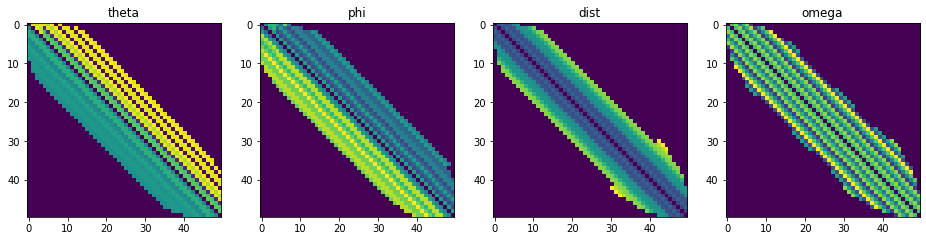

In [9]:
# plot background distribution, for each feature of length 50
plot_feat(bkg[50])

In [33]:
# WARNING, for demo we use n_models=1, in practice you should ALWAYS use n_models=5
# note, for hallucination design we find that "sample" mode works better
model = mk_design_model(add_bkg=True, n_models=1, sample=True, pssm_design=True)

mode: pssm design
loading model: xaa
The loss function is composed of the following: ['bkg']


In [28]:
# WARNING (return_traj=True) will return the predicted structure at EVERY iteration
# you may want to set this to False for production runs, as you will quickly run out of memory

# let's design a protein of length 50
_bkg = bkg[50][None]
design = model.design(inputs={"bkg":_bkg}, opt_iter=200, return_traj=True)

10 loss:{'bkg':-0.51463616}
20 loss:{'bkg':-0.846112}
30 loss:{'bkg':-0.83820146}
40 loss:{'bkg':-1.1771606}
50 loss:{'bkg':-1.1802415}
60 loss:{'bkg':-1.2402039}
70 loss:{'bkg':-1.2544445}
80 loss:{'bkg':-1.3103279}
90 loss:{'bkg':-1.2669848}
100 loss:{'bkg':-1.3129902}
110 loss:{'bkg':-1.3184301}
120 loss:{'bkg':-1.3236028}
130 loss:{'bkg':-1.3194486}
140 loss:{'bkg':-1.3200804}
150 loss:{'bkg':-1.3206071}
160 loss:{'bkg':-1.331587}
170 loss:{'bkg':-1.3263628}
180 loss:{'bkg':-1.1684605}
190 loss:{'bkg':-1.3264464}
200 loss:{'bkg':-1.3421421}
FINAL loss:{'bkg':-1.3391334}


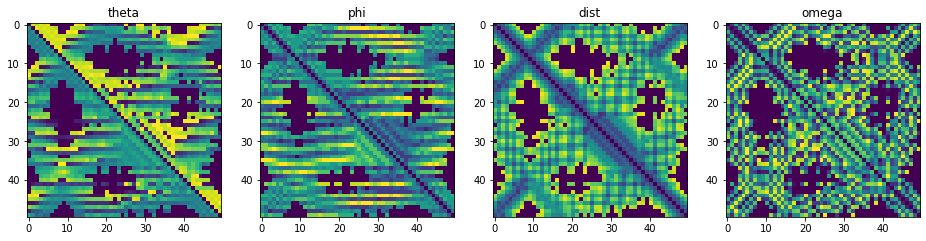

In [35]:
plot_feat(design["feat"])

What are these "features"?
These are the 6D transformation for every pair of residues.

![6D transformation](https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/notebooks/6D.png)

In [29]:
# the reported loss it the Kullback–Leibler divergence between
# the predicted features and the background features
# we try to "hallucinate" a protein that matches the background distribution of these features!
-0.25 * (design["feat"] * np.log(design["feat"]/_bkg)).sum(-1).mean()

-1.3391339778900146

In [30]:
# sequence of the design
N_to_AA(design["I"].argmax(-1))

['RIVIRIEYPDKTFEVPILDEIPDHPFDEMPDQIEKHCNMPGFRKIDIEPV']

In [31]:
# Here we animate:
# Left: the predicted distance feature during optimization
# Right: the designed sequence (shown as the prob(aa) at each position)
HTML(animate(design))

## But.. but, how do I see my protein... in 3D?
Normally we'd input the predicted constraints (or features) into PyRosetta for structure prediction... but since this is quite expensive to run in Google Colab, for demo purposes let's use a quick approximation (secret recipe) that converts the 6D features into a full 3D structure!

In [32]:
get_pdb(design,"my_design.pdb")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#**PART 2** - Design a new sequence for a given protein backbone!
![the protocol](https://raw.githubusercontent.com/gjoni/trDesign/master/02-GD/notebooks/figure_1.png)

## Load features from PDB

In [36]:
pdb = prep_input("1QYS.pdb", chain="A")
_feat = pdb["feat"]
_seq = np.eye(20)[AA_to_N(pdb["seq"])]

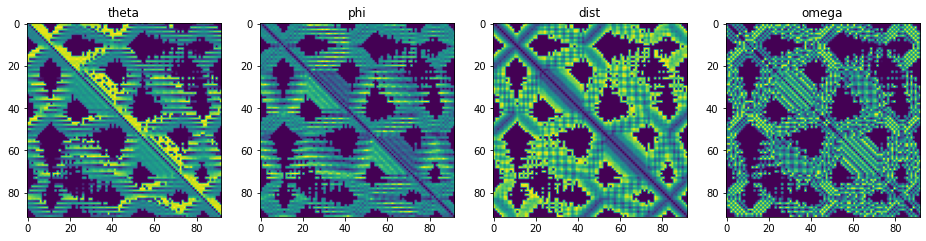

In [37]:
plot_feat(_feat)

## setup design run

In [38]:
# WARNING, for demo we use n_models=1, in practice you should ALWAYS use n_models=5
model = mk_design_model(add_pdb=True, n_models=1)

mode: single sequence design
loading model: xaa
The loss function is composed of the following: ['pdb']


make a prediction using native sequence

In [39]:
pred = model.predict(inputs={"I":_seq[None,None],"pdb":_feat[None]})

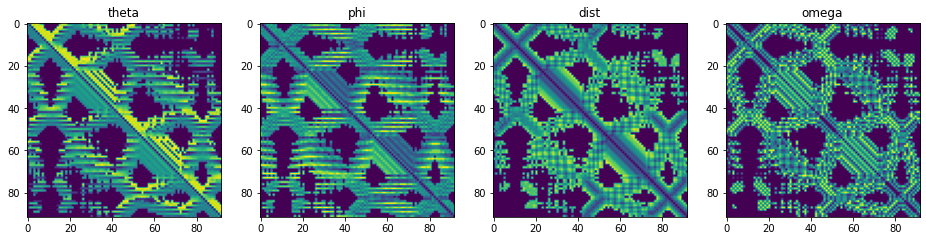

In [40]:
plot_feat(pred["feat"])

In [41]:
# measure of contact accuracy
get_dist_acc(pred["feat"],_feat)

array([0.7734046])

## Let's design a new sequence to match these features derived from the PDB file!

In [42]:
design = model.design(inputs={"pdb":_feat[None]}, return_traj=True)

10 loss:{'pdb':2.2341528}
20 loss:{'pdb':1.6389086}
30 loss:{'pdb':1.5150689}
40 loss:{'pdb':1.4261475}
50 loss:{'pdb':1.3035057}
60 loss:{'pdb':1.2807952}
70 loss:{'pdb':1.2918684}
80 loss:{'pdb':1.2814386}
90 loss:{'pdb':1.2781128}
100 loss:{'pdb':1.2870549}
FINAL loss:{'pdb':1.2649664}


In [43]:
# the reported loss it the categorical cross entropy
-(_feat * np.log(design["feat"])).sum(-1).mean()/4

1.2649665223203432

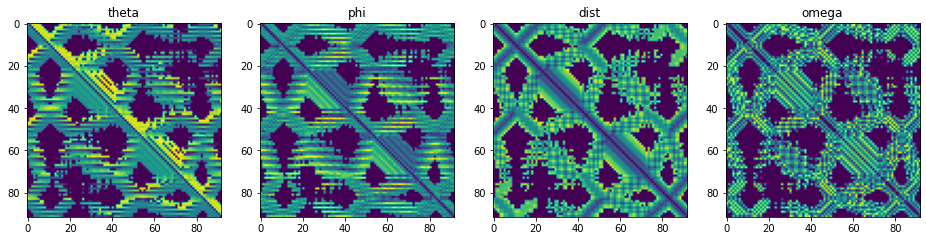

In [44]:
plot_feat(design["feat"])

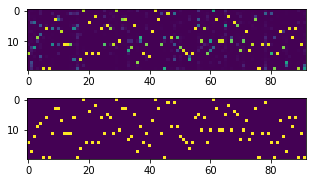

['PWMIHVEVKDDGKKKEVTAPCPNPEKQEKALDDFMQWIPKSGADKVRIRIMFPTPEQLEPLADLLQNLCQFLGFKDVKRKPVPGMWEIEVKV']

In [45]:
plt.figure(figsize=(5,3))
plt.subplot(2,1,1)
plt.imshow(design["I_pssm"][0].T)
plt.subplot(2,1,2)
plt.imshow(np.eye(20)[design["I"][0].argmax(-1)].T)
plt.show()

N_to_AA(design["I"].argmax(-1))

## Let's make a movie!

In [46]:
HTML(animate(design))

In [47]:
get_pdb(design,"1QYS_redesign.pdb")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol